In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
# from ipywidgets import *

from typing import Union

import numpy as np
import pandas as pd
from scipy.linalg import expm
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn import neighbors, clone


from pyfrechet.metric_spaces import MetricData, Euclidean, LogCholesky, spd_to_log_chol, log_chol_to_spd
# from pyfrechet.regression.frechet_regression import LocalFrechet, GlobalFrechet
# from pyfrechet.regression.kernels import NadarayaWatson, gaussian, epanechnikov
# from pyfrechet.regression.knn import KNearestNeighbours
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from pyfrechet.metrics import mse

INFO: Using numpy backend


In [2]:
def sim_matrix_normal_one(M: np.ndarray, var: float,
                      random_state: Union[None, int]=None) -> np.ndarray:
    """
    Sample one observation from a symmetric matrix variate normal distribution with mean
    matrix M and variance parameter var. See:

    REFERENCE:
    Qi Zhang, Lingzhou Xue, and Bing Li. Dimension reduction for Fréchet regression. Journal of the
    American Statistical Association, pages 1-15, 2023.
    """
    d=M.shape[0]
    np.random.seed(random_state)
    Z=np.zeros(shape=(d,d))
    Z[np.diag_indices(d)]=np.random.normal(size=d, loc=0, scale=1)
    Z[np.tril_indices(d, k=-1)]=np.random.normal(size=np.tril_indices(d, k=-1)[0].size, loc=0, scale=0.5)
    Z[np.triu_indices(d, k=1)]=Z[np.tril_indices(d, k=-1)]
    A=M+np.sqrt(var)*Z
    return A

def sim_matrix_normal(M: np.ndarray, var: float,
                      size: int=1,
                      random_state: Union[None, int]=None) -> list:
    """
    Returns (a list) a sample of the size specified from a symmetric matrix variate normal distribution
    with mean matrix M and variance parameter var.
    (See sim_matrix_normal_one() function for details)
    """
    d=M.shape[0]
    np.random.seed(random_state)
    sample=[]

    for n in range(size):
        sample.append(sim_matrix_normal_one(M, var))
    return sample

In [12]:
M=np.array([[1,2,3],
            [2,5,4],
            [3,4,0]])

sim_matrix_normal_one(M, 1)

array([[0.29374738, 2.44858086, 3.33510564],
       [2.44858086, 5.20373364, 3.52298998],
       [3.33510564, 3.52298998, 0.56407421]])

In [117]:
M=np.array([[1,2,3],
            [2,5,4],
            [3,4,0]])

sim_matrix_normal(M, 1, size=3, random_state=100)

[array([[1.73183679, 1.64352189, 3.1050673 ],
        [1.64352189, 3.81393386, 3.89406265],
        [3.1050673 , 3.89406265, 1.50385249]]),
 array([[0.59656439, 1.66517604, 3.34273242],
        [1.66517604, 5.17889745, 3.38975502],
        [3.34273242, 3.38975502, 0.03211604]]),
 array([[-0.28297526,  2.18016443,  2.8083158 ],
        [ 2.18016443,  5.71535414,  3.70793655],
        [ 2.8083158 ,  3.70793655, -0.17300143]])]

## Scenario 1

In [13]:
def rho(X: np.ndarray, beta: np.ndarray) -> float:
    return np.cos(4*np.pi*np.dot(X, beta))

def DX(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    return np.array([[1, rho(X, beta)],
                     [rho(X, beta), 1]])


In [14]:
beta2=np.array([0.75, 0.25])
beta5=np.array([0.1, 0.2, 0.3, 0.4, 0])
beta10=np.array([0.1, 0.2, 0.3, 0.4, 0, 0, 0, 0, 0, 0])
beta20=np.zeros(shape=20); beta20[[0,1,2,3]]=[0.1, 0.2, 0.3, 0.4]; beta20[[-4, -3, -2, -1]]=[0.1, 0.2, 0.3, 0.4]; beta20=beta20/2

In [15]:
def sim_DX(beta: np.ndarray, size: int):
    sampleX=[]
    sample=[]
    for n in range(size):
        X=np.random.uniform(size=beta.size)
        sampleX.append(X)
        sample.append(DX(X, beta))

    return (sampleX, sample)

In [78]:
sim_DX(beta2, size=3)

([array([0.89132195, 0.20920212]),
  array([0.18532822, 0.10837689]),
  array([0.21969749, 0.97862378])],
 [array([[ 1.        , -0.93339414],
         [-0.93339414,  1.        ]]),
  array([[ 1.        , -0.49371541],
         [-0.49371541,  1.        ]]),
  array([[1.        , 0.41927664],
         [0.41927664, 1.        ]])])

### $p=2$

In [16]:
sample_DX=sim_DX(beta2, size=200)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2, random_state=100))

sample_logY

[array([[0.21748109, 0.83572186],
        [0.83572186, 1.15325134]]),
 array([[0.21748109, 0.39736984],
        [0.39736984, 1.15325134]]),
 array([[0.21748109, 0.16754587],
        [0.16754587, 1.15325134]]),
 array([[ 0.21748109, -0.34507703],
        [-0.34507703,  1.15325134]]),
 array([[ 0.21748109, -0.6139578 ],
        [-0.6139578 ,  1.15325134]]),
 array([[ 0.21748109, -0.68286479],
        [-0.68286479,  1.15325134]]),
 array([[0.21748109, 0.91173302],
        [0.91173302, 1.15325134]]),
 array([[ 0.21748109, -0.67273832],
        [-0.67273832,  1.15325134]]),
 array([[ 0.21748109, -0.36469366],
        [-0.36469366,  1.15325134]]),
 array([[ 0.21748109, -0.65026033],
        [-0.65026033,  1.15325134]]),
 array([[0.21748109, 0.42318868],
        [0.42318868, 1.15325134]]),
 array([[ 0.21748109, -0.73294221],
        [-0.73294221,  1.15325134]]),
 array([[ 0.21748109, -0.598253  ],
        [-0.598253  ,  1.15325134]]),
 array([[ 0.21748109, -0.12930036],
        [-0.12930036, 

In [17]:
sampleY=[expm(A) for A in sample_logY]
sampleY

[array([[1.88934749, 1.92394498],
        [1.92394498, 4.0436174 ]]),
 array([[1.38234681, 0.8390467 ],
        [0.8390467 , 3.35822634]]),
 array([[1.26744389, 0.34635158],
        [0.34635158, 3.20187234]]),
 array([[ 1.34771265, -0.72403878],
        [-0.72403878,  3.31114074]]),
 array([[ 1.58217326, -1.34305408],
        [-1.34305408,  3.62920327]]),
 array([[ 1.66587993, -1.51529593],
        [-1.51529593,  3.74238008]]),
 array([[2.02119349, 2.143069  ],
        [2.143069  , 4.22076306]]),
 array([[ 1.65293779, -1.48955826],
        [-1.48955826,  3.72489392]]),
 array([[ 1.36010622, -0.76693638],
        [-0.76693638,  3.32799415]]),
 array([[ 1.62500441, -1.43296225],
        [-1.43296225,  3.68713763]]),
 array([[1.40134499, 0.89664505],
        [0.89664505, 3.38403925]]),
 array([[ 1.73320696, -1.64487771],
        [-1.64487771,  3.83327378]]),
 array([[ 1.56450492, -1.30470674],
        [-1.30470674,  3.6052899 ]]),
 array([[ 1.25751996, -0.26679293],
        [-0.26679293, 

In [23]:
X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=2)
y=MetricData(M, sampleY_LogChol)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [25]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=2,
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(mtry=2, split_type='2means'), n_jobs=4)

In [26]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.661007681850269
MSE: 0.4806090213996592


In [27]:
oob_errors=forest.oob_errors()

In [28]:
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

1.0

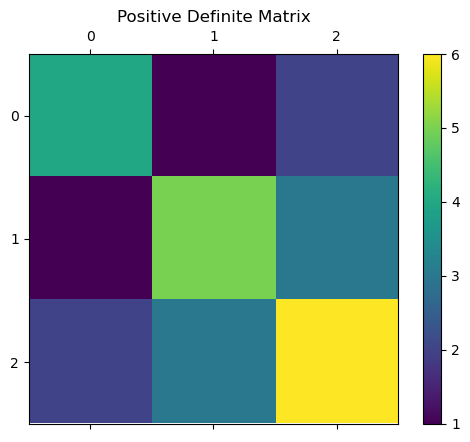

In [118]:
# IDEA FROM CHATGPT

def visualize_positive_definite_matrix(matrix):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='viridis')

    # Add colorbar
    fig.colorbar(cax)

    plt.title('Positive Definite Matrix')
    plt.show()

# Example: visualize a 3x3 positive definite matrix
matrix = np.array([[4, 1, 2],
                   [1, 5, 3],
                   [2, 3, 6]])

visualize_positive_definite_matrix(matrix)

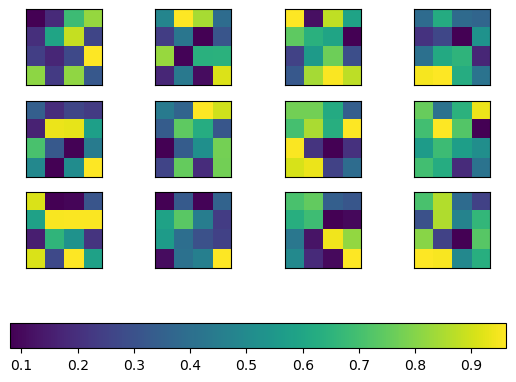

In [29]:
def visualize_positive_definite_matrices(matrices, layout: Union[tuple, None]=None):
    """
    layout=(num_rows, num_cols)
    """
    if not layout:
        num_cols = int(np.ceil(np.sqrt(num_matrices)))
        num_rows = int(np.ceil(num_matrices / num_cols))
    else:
        num_rows=layout[0]
        num_cols=layout[1]

    fig, axs = plt.subplots(num_rows, num_cols)

    # Loop through the matrices and plot them
    for i, matrix in enumerate(matrices):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        cax = ax.matshow(matrix, cmap='viridis')
        # ax.set_title(f'Matrix {i+1}')

        ax.set_xticks([])
        ax.set_yticks([])

    # Create a single colorbar for all matrices
    fig.colorbar(cax, ax=axs.ravel().tolist(), location='bottom')
    plt.show()

# Example: visualize multiple 3x3 positive definite matrices
matrix_size = 4
num_matrices = 12
matrices = [np.random.rand(matrix_size, matrix_size) for _ in range(num_matrices)]
visualize_positive_definite_matrices(matrices)

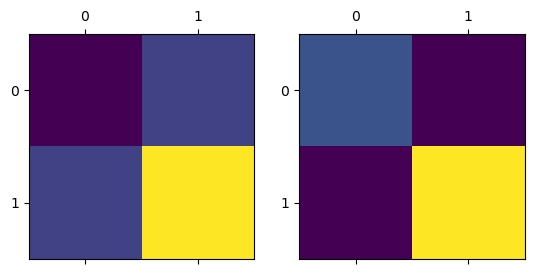

In [30]:
fig, ax = plt.subplots(1,2)
ax[0].matshow(log_chol_to_spd(y_test.data[15]), cmap='viridis')
ax[1].matshow(log_chol_to_spd(forest_predictions.data[15]), cmap='viridis')

# Add colorbar
# fig.colorbar(cax)
plt.show()

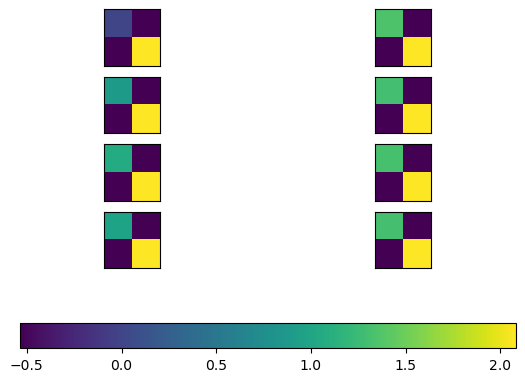

In [31]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

In [32]:
Dalpha

7.529495971530416

### $p=10$

In [165]:
sample_DX=sim_DX(beta10, size=100)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2**2, random_state=100))

sampleY=[expm(A) for A in sample_logY]

X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=10)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [166]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=3, # Take sqrt(predictor variables)
            min_split_size=5)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(mtry=3, split_type='2means'), n_jobs=4)

In [167]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

MSE: 1.3376304607623786
MSE: 1.1772629141757591


1.0

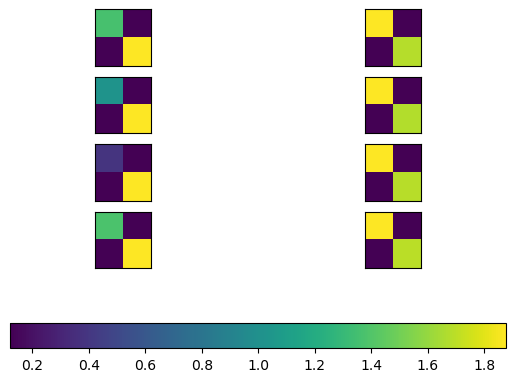

In [169]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

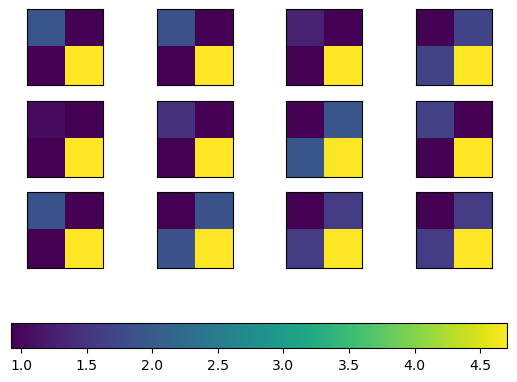

In [195]:
visualize_positive_definite_matrices(sampleY[2:14])

## Scenario 2

In [33]:
def rho1(X: np.ndarray, beta1: np.ndarray) -> float:
    return 0.8*np.cos(4*np.pi*np.dot(X, beta1))

def rho2(X: np.ndarray, bata2: np.ndarray) -> float:
    return 0.4*np.cos(4*np.pi*np.dot(X, beta2))

def DX(X: np.ndarray, beta1: np.ndarray, beta2: np.ndarray) -> np.ndarray:
    return np.array([[1, rho1(X, beta1), rho2(X, beta2)],
                     [rho1(X, beta1), 1, rho1(X, beta1)],
                     [rho2(X, beta2), rho1(X, beta1), 1]])

In [34]:
beta1_2=np.array([0.75, 0.25]); beta2_2=np.array([0.75, 0.25])
beta1_5=np.array([0.1, 0.2, 0.3, 0.4, 0]); beta2_5=np.array([0, 0.1, 0.2, 0.3, 0.4])
beta1_10=np.array([0.1, 0.2, 0.3, 0.4, 0, 0, 0, 0, 0, 0]); beta2_10=np.array([0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.3, 0.4])
beta1_20=np.zeros(shape=20); beta1_20[[0,1,2,3]]=[0.1, 0.2, 0.3, 0.4]
beta2_20=np.zeros(shape=20); beta2_20[[-4,-3,-2,-1]]=[0.1, 0.2, 0.3, 0.4]
